# Data visualization Notebook

## Objectives

* produce Data Visualization to allow for visual differentation of healthy and infected cherry leaves.

## Inputs

* inputs/cherry_leaves_data/cherry-leaves/test
* inputs/cherry_leaves_data/cherry-leaves/train
* inputs/cherry_leaves_data/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file
* Average and variablity of images per label plot
* Plot to illustrate contrast between healthy cherry leaves and infected leaves
* Generate an image montage for healthy cherry leaves and infected leaves.

### Insights | Conclusions
* all image dimensions are 256px by 256px but will be made smaller to limit space
* from the average Images you can see that a healthy leaf has a more consistant green colour on the face of the leaf while



---

## Change working directory

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

We will change the working directory from its current folder to its parent folder using the method os.cetcwd.


In [2]:
working_dir = os.getcwd()
working_dir

'/workspace/showMeMildew/jupiter_notebooks'

here we make the parent of our current directory to the current directory
*  we pass os.path.dirname() as an arguement which gets the parent directory




In [3]:
os.chdir(os.path.dirname(working_dir))

to confirm we have changed our directory

In [4]:
working_dir = os.getcwd()
working_dir

'/workspace/showMeMildew'

## Set Data directories

### Set Input Directory

In [5]:
root_data_dir = 'inputs/cherry_leaves_data/cherry-leaves/'
train_dir = os.path.join(root_data_dir, 'train')
test_dir = os.path.join(root_data_dir, 'test')
validation_dir = os.path.join(root_data_dir, 'validation')

Set Output directory

In [6]:
version = 'v1.0'

file_path = f'outputs/{version}'
version_file_path = os.path.join(working_dir, file_path)

if os.path.exists(version_file_path):
    print(f"This version {version} already exists. please create a new version")
    pass
else:
    os.makedirs(name=file_path)

This version v1.0 already exists. please create a new version


## Set Label names

In [7]:
labels = os.listdir(train_dir)
print('images labels are: ', labels)

images labels are:  ['healthy', 'powdery_mildew']


---

## Data visualisation of image data

### Image shape

Calculate average dimensions

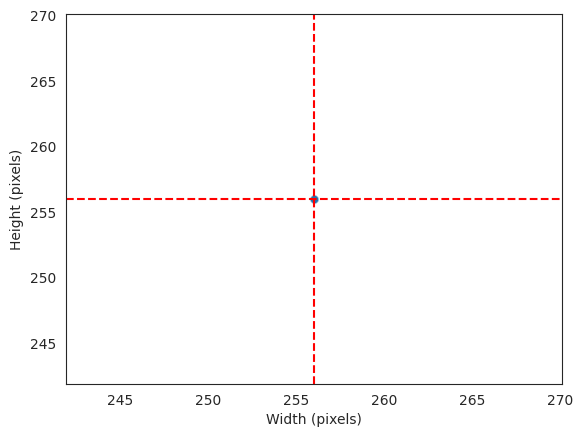

In [8]:
"""
Calculates the average dimensions of the images in the dataset
"""

height, width = [], []
for label in labels:
  for image_filename in os.listdir(train_dir + '/'+ label):
    img = imread(train_dir + '/' + label + '/'+ image_filename)
    dimension1, dimension2, colors = img.shape
    height.append(dimension1) # image height
    width.append(dimension2) # image width

fig, axes = plt.subplots()
sns.scatterplot(x=width, y=height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
height_mean = int(np.array(height).mean())
width_mean = int(np.array(width).mean())
axes.axvline(x=height_mean,color='r', linestyle='--')
axes.axhline(y=width_mean,color='r', linestyle='--')
plt.show()


#### Set the image shape


the mean dimentions for images in the dataset is 256 x 256, however using these dimentions for every image in the dataset could potentially cause the model to exceed 100MB. for a smoother push we will limited the size to 120 by 120. the final argument refers to the 3 dimensions of the RGB color channels.

In [9]:
image_shape = (100, 100, 3)
image_shape

(100, 100, 3)

save the image embeddings

In [10]:
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pk1")

['outputs/v1.0/image_shape.pk1']

## Average and variability of images per label

### Function to load images in an array (tensor)

In [11]:
from tensorflow.keras.preprocessing import image

def loadImageAsArray(myDataDir, newSize=(50,50), nImagesPerLabel = 20):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(myDataDir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(myDataDir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < nImagesPerLabel:
        
        img = image.load_img(myDataDir + '/' + label + '/' + image_filename, target_size=newSize)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, newSize[0], newSize[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

2023-04-03 17:35:03.897976: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 17:35:03.898013: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Load image shape and labels into array

In [12]:
X, y = loadImageAsArray(myDataDir=train_dir,
                           newSize=image_shape,
                          nImagesPerLabel = 30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


### Plot and save average and variability of images per label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12,5), save_image=False):
  """
  here we loop through labels and subset an array for that given label.
  we then calculate the average and standard deviation, and create a figure
  showing the product. finally we save the image.

  """

  for label_to_display in np.unique(y):
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    axes[0].set_title(f"Average Image for label {label_to_display}")
    axes[0].imshow(avg_img, cmap='gray')
    axes[1].set_title(f"Variability image for label {label_to_display}")
    axes[1].imshow(std_img, cmap='gray')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


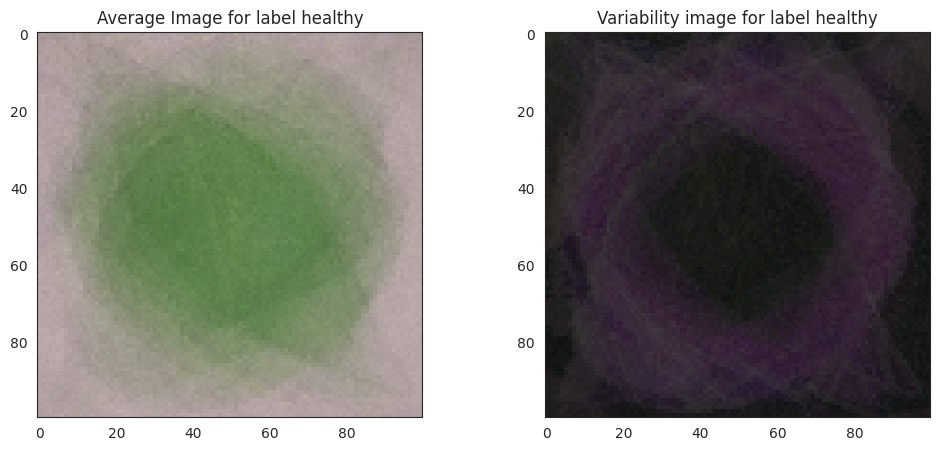

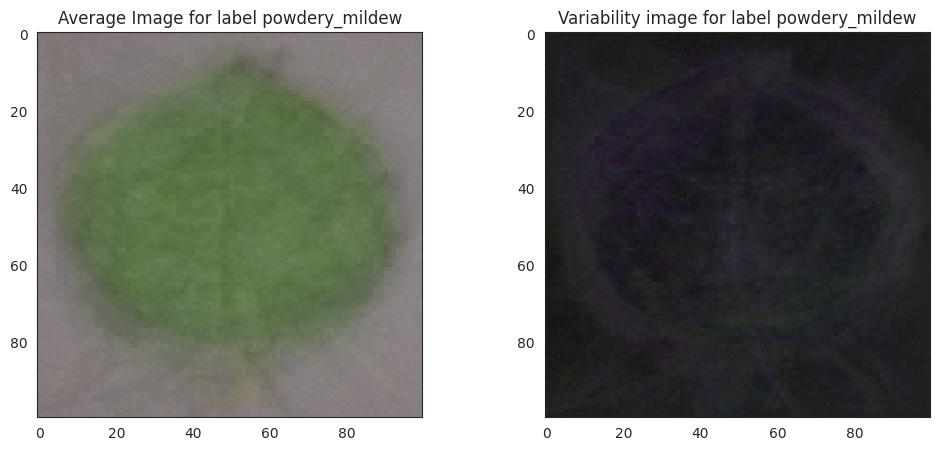

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)


### Difference between average healthy cherry leaf and infected leaf images

In [15]:
def subset_image_label(X,y,label_to_display):
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


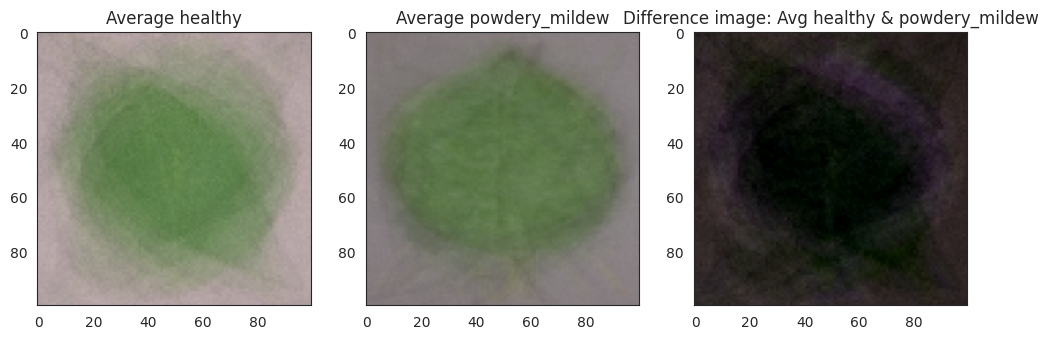

In [16]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='healthy', label_2='powdery_mildew',
                                        figsize=(12,10),
                                        save_image=True
                                        )

## Image Montage

In [17]:
import itertools
import random

"""
the process is as follows

if a label exists in a folder then:
  compare the montage space to subset size, montage space must be greater
  create axes indices from the nrows and ncols
  display the montage
"""

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15,10)):
  

  labels = os.listdir(dir_path)

  # subset the class you want displaying
  if label_to_display in labels:

    # compares montage space against subset size
    images_list = os.listdir(dir_path+'/'+ label_to_display)
    if nrows * ncols < len(images_list):
      img_idx = random.sample(images_list, nrows * ncols)
    else:
      print(
          f"Space limit exceeded, please lower nrows or ncols. \n"
          f"Your subset contains {len(images_list)} images. "
          f"You tried {nrows * ncols}")
      return
    

    # create indices from nrows and ncols
    list_rows= range(0,nrows)
    list_cols= range(0,ncols)
    plot_idx = list(itertools.product(list_rows,list_cols))


    # display figures
    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)
    for x in range(0,nrows*ncols):
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    plt.tight_layout()
    plt.show()


  else:
    print("that label doesn't exist.")
    print(f"please pick from the following labels: {labels}")

healthy


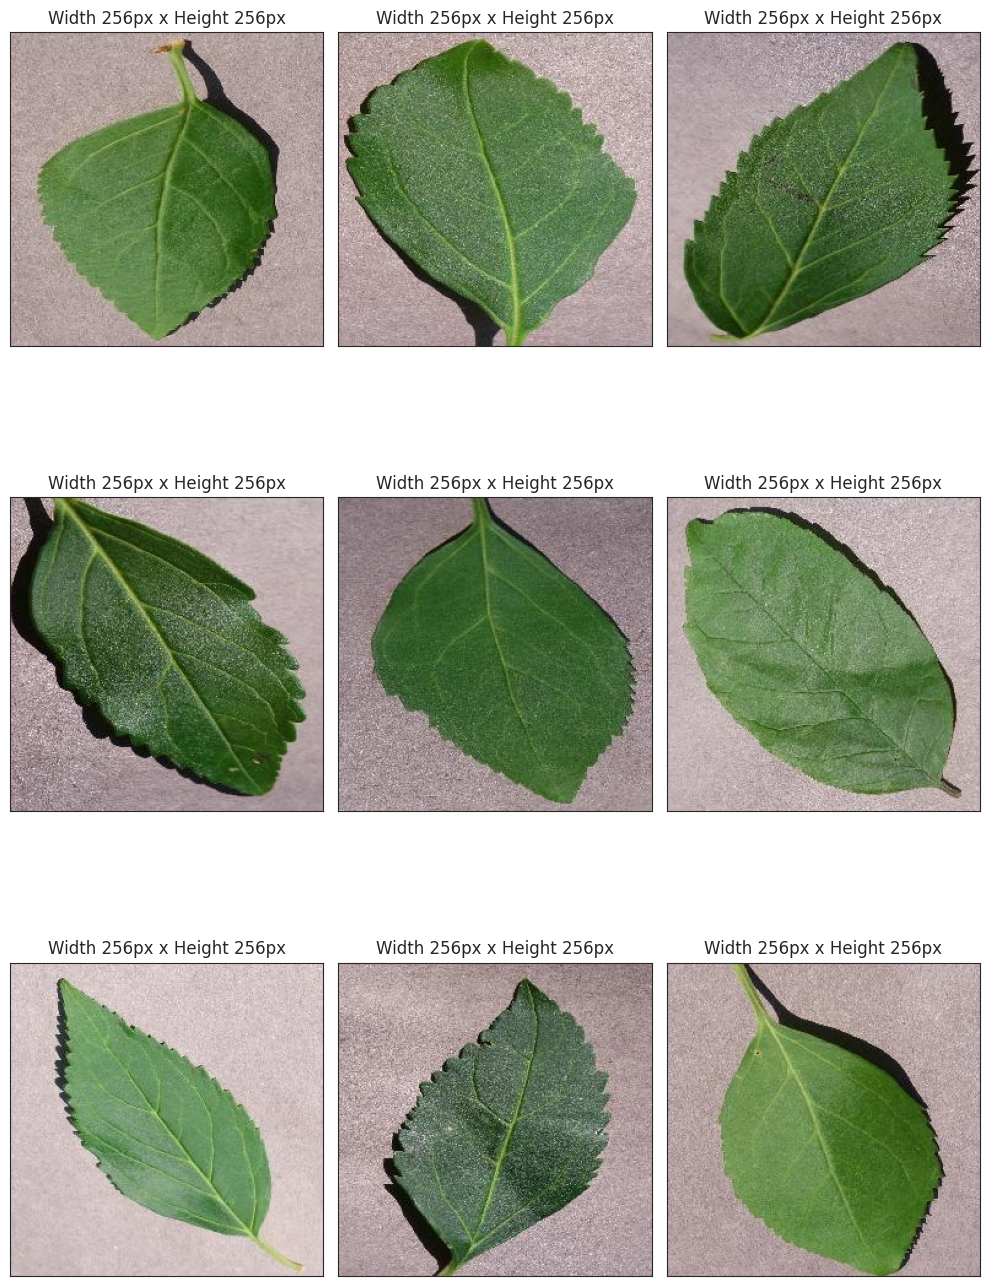



powdery_mildew


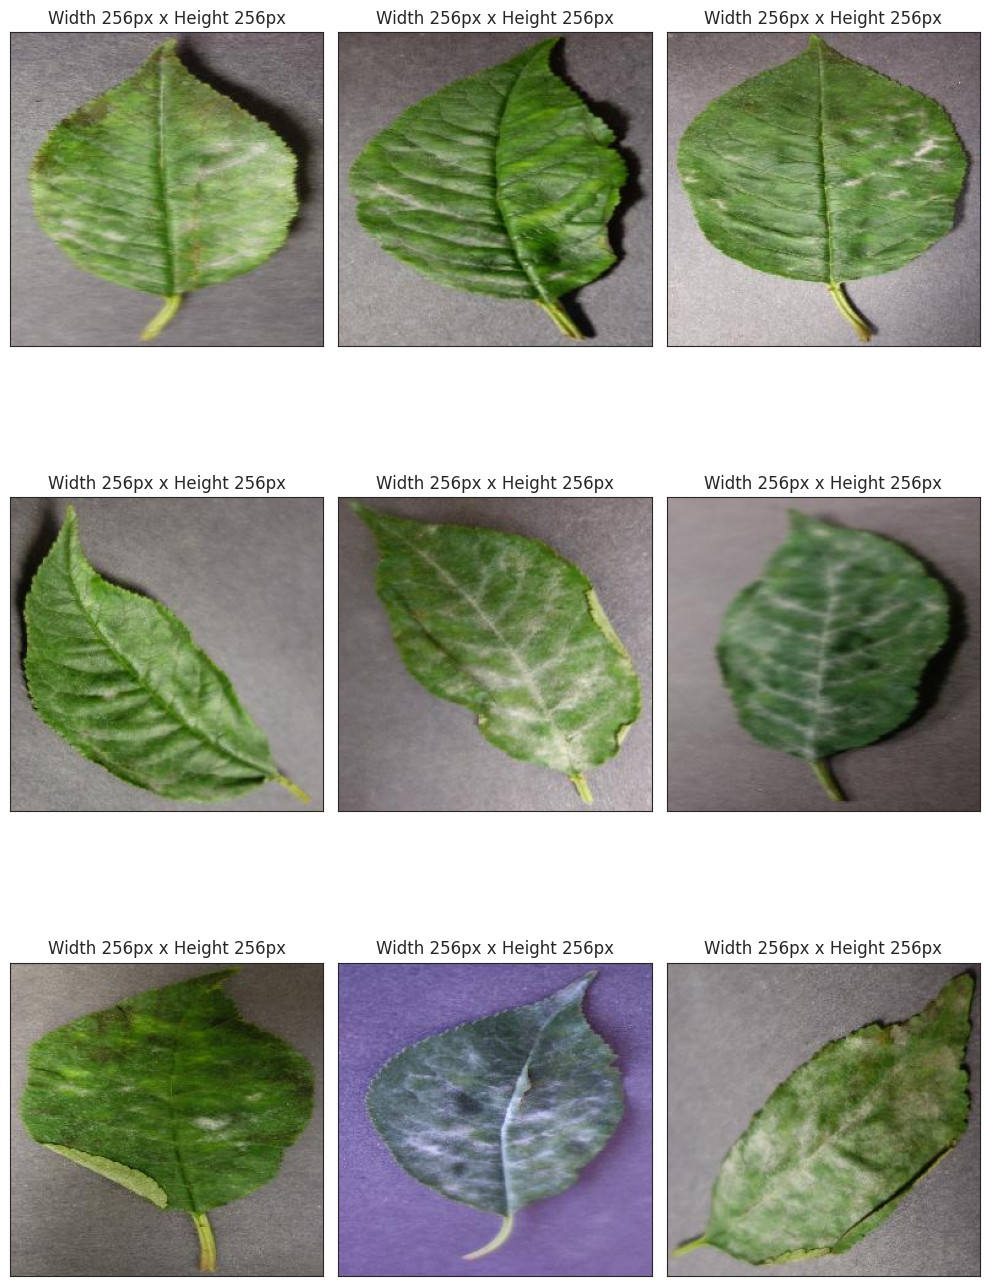

In [18]:
for label in labels:
  print(label)
  image_montage(dir_path= train_dir,
                label_to_display= label,
                nrows=3, ncols=3,
                figsize=(10,15)
                )
  print("\n")